##### ARIMA and GRACH model has been used here to match variation and stock price difference from previous trading day

In [7]:
import numpy as np
import pandas as pd
from pandas import datetime
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
import arch
from statsmodels.tsa.arima.model import ARIMA

C:\Users\soumya\AppData\Local\Temp\ipykernel_8324\1405005639.py:3: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime


In [8]:
df = pd.read_csv('data_model.csv', header=0, parse_dates=[0])[['Date','Diff','Diff_t+1']]
df_cleaned = df.dropna()
df_cleaned.head(5)

,Date,Diff,Diff_t+1
1,2021-04-28,211.50,30.35
2,2021-04-29,30.35,-263.80
3,2021-04-30,-263.80,3.05
4,2021-05-03,3.05,-137.65
5,2021-05-04,-137.65,121.35


In [9]:
result = adfuller(df_cleaned['Diff'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -12.021791
p-value: 0.000000


c:\ProgramData\Anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


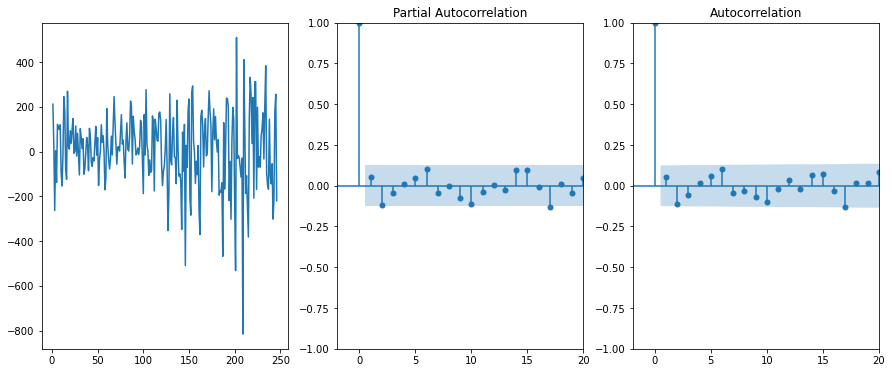

In [10]:
fig, axes = plt.subplots(1, 3,figsize=(15,6))
axes[0].plot(df_cleaned['Diff'])
axes[1].set(ylim=(-1,2))
axes[1].set(xlim=(-2,20))
plot_pacf(df_cleaned['Diff'], ax=axes[1])
axes[2].set(ylim=(-1,2))
axes[2].set(xlim=(-2,20))
plot_acf(df_cleaned['Diff'], ax=axes[2])

plt.show()

In [11]:
def predict(coef, history):
	yhat = 0.0
	for i in range(1, len(coef)+1):
		yhat += coef[i-1] * history[-i]
	return yhat

def difference(dataset):
	diff = list()
	for i in range(1, len(dataset)):
		value = dataset[i] - dataset[i - 1]
		diff.append(value)
	return np.array(diff)

X = df_cleaned['Diff'].values
size = len(X) - 100
train, test = X[0:size], X[size:]
history = [x for x in train]

predictions = list()
actual = list()
for t in range(len(test)):
	model = ARIMA(history, order=(1,0,1))
	model_fit = model.fit()
	ar_coef, ma_coef = model_fit.arparams, model_fit.maparams
	resid = model_fit.resid
	diff = difference(history)

	garch = arch.arch_model(resid, p=1, o=0, q=1)
	garch_fitted = garch.fit()
	garch_forecast = garch_fitted.forecast(horizon=1)
	predicted_et = garch_forecast.mean['h.1'].iloc[-1]

	yhat = history[-1] + predict(ar_coef, diff) + predict(ma_coef, resid) + predicted_et
	predictions.append(yhat)
	obs = test[t]
	actual.append(obs)
	# print('>t-1_actual=%.3f, predicted=%.3f, expected=%.3f' % (history[-1], yhat, obs))
	history.append(obs)
 
from IPython.display import clear_output
clear_output()

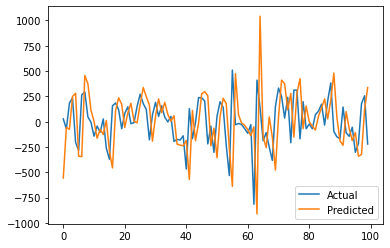

Directional error percentage: 56.99999999999999


In [12]:
# Actual vs Fitted
plt.plot(actual)
plt.plot(predictions)
plt.legend(["Actual", "Predicted"], loc ="lower right")
plt.show()

x=0
for i in range(len(actual)):
    if actual[i]*predictions[i]>0:
        x=x+1

print("Directional error percentage:", x/len(actual)*100)